# Step 1. Setup Env
!pip install git+https://github.com/criteo-research/reco-gym.git@course

In [1]:
from recogym.envs.session import OrganicSessions

from numpy.random.mtrand import RandomState
from recogym import Configuration, DefaultContext, Observation
from recogym.agents import Agent
from recogym.agents import organic_user_count_args, OrganicUserEventCounterAgent
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from recogym.evaluate_agent import verify_agents, plot_verify_agents
from recogym.agents import FeatureProvider

import math
import gym
from copy import deepcopy
from recogym import env_1_args
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

In [2]:
def get_recogym_configuration(num_products, random_seed=42):
    return Configuration({
        **env_1_args, 
        'random_seed': random_seed,
        'num_products': num_products,
        # 'phi_var': 0.0,
        # 'sigma_mu_organic': 0.,
        # 'sigma_omega': 0.,
        # 'K': 5,
        # 'number_of_flips': 5,
    })


def get_environement(num_products, random_seed=42):
    env = gym.make('reco-gym-v1')
    env.init_gym(get_recogym_configuration(num_products, random_seed=random_seed).__dict__)
    
    return env

# Step 2. Generate the training data and derive the raw features

In [3]:
NUM_USERS = 1000
NUM_PRODUCTS = 10

organic_counter_agent = OrganicUserEventCounterAgent(Configuration({
           **organic_user_count_args,
           **get_recogym_configuration(NUM_PRODUCTS).__dict__,
           'select_randomly': True,
       }))

popularity_policy_logs = get_environement(NUM_PRODUCTS).generate_logs(NUM_USERS, organic_counter_agent)

In [4]:
class ProductCountFeatureProvider(FeatureProvider):
    """This feature provider creates a user state based on viewed product count.
    Namely, the feature vector of shape (n_products, ) contains for each product how many times the
    user has viewed them organically.
    """

    def __init__(self, config):
        super(ProductCountFeatureProvider, self).__init__(config)
        self.feature_data = np.zeros((self.config.num_products)).astype(int)

    def observe(self, observation):
        for session in observation.sessions():
            self.feature_data[int(session['v'])] += 1

    def features(self, observation):
        return self.feature_data.copy()

    def reset(self):
        self.feature_data[:] = 0


def build_rectangular_data(logs, feature_provider):
    """Create a rectangular feature set from the logged data.
    For each taken action, we compute the state in which the user was when the action was taken
    """
    user_states, actions, rewards, proba_actions = [], [], [], []
    
    current_user = None
    for _, row in logs.iterrows():
        if current_user != row['u']:
            # Use has changed: start a new session and reset user state
            current_user = row['u']
            sessions = OrganicSessions()
            feature_provider.reset()
        
        context = DefaultContext(row['u'], row['t'])
        
        if row['z'] == 'organic':
            sessions.next(context, row['v'])
            
        else:
            # For each bandit event, generate one observation for the user state, the taken action
            # the obtained reward and the used probabilities
            feature_provider.observe(Observation(context, sessions))
            user_states += [feature_provider.features(None)] 
            actions += [row['a']]
            rewards += [row['c']]
            proba_actions += [row['ps']] 
            
            # Start a new organic session
            sessions = OrganicSessions()
    
    return np.array(user_states), np.array(actions).astype(int), np.array(rewards), np.array(proba_actions)

In [5]:
# You can now see data that will be provided to our agents based on logistic regressions
feature_provider = ProductCountFeatureProvider(config=get_recogym_configuration(NUM_PRODUCTS))
user_states, actions, rewards, proba_actions = build_rectangular_data(popularity_policy_logs, feature_provider)

In [6]:
preview_start, preview_size = 500, 10

print('user product views count at action time')
print(user_states[preview_start:preview_start + preview_size])
print('taken actions', actions[preview_start:preview_start + preview_size])
print('obtained rewards', rewards[preview_start:preview_start + preview_size])
print('action probablities', proba_actions[preview_start:preview_start + preview_size])

user product views count at action time
[[0 0 0 1 1 5 0 0 0 0]
 [0 0 0 1 2 7 0 0 0 0]
 [0 0 0 1 2 7 0 0 0 0]
 [0 0 0 1 2 7 0 0 0 0]
 [0 0 0 1 2 7 0 0 0 0]
 [0 0 0 1 2 7 0 0 0 0]
 [0 0 0 1 2 7 0 0 0 0]
 [0 0 0 1 2 7 0 0 0 0]
 [0 0 0 1 2 7 0 0 0 0]
 [0 0 0 1 2 7 0 0 0 0]]
taken actions [5 5 5 5 5 4 5 5 5 5]
obtained rewards [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
action probablities [0.71428571 0.7        0.7        0.7        0.7        0.2
 0.7        0.7        0.7        0.7       ]


# Step 3.A. Define and train the bandit likelihood agent

In order to be able to make the link between the state and the actions, we need to create cross-features that show how good a certain pair of state,action is from the pv of predicting pClick (pReward)

In [7]:
class LikelihoodAgent(Agent):
    def __init__(self, feature_provider, use_argmax=False, seed=43):
        self.feature_provider = feature_provider
        self.use_argmax = use_argmax
        self.random_state = RandomState(seed)
        self.model = None
        
    @property
    def num_products(self):
        return self.feature_provider.config.num_products
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state.
        """
        features = np.zeros(len(user_state) * self.num_products)
        features[action * len(user_state): (action + 1) * len(user_state)] = user_state
        
        return features
    
    def train(self, logs):
        user_states, actions, rewards, proba_actions = build_rectangular_data(logs, self.feature_provider)
        
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])
        self.model = LogisticRegression(solver='lbfgs', max_iter=5000)
        self.model.fit(features, rewards)

    
    def _score_products(self, user_state):
        all_action_features = np.array([
            self._create_features(user_state, action) 
            for action in range(self.num_products)
        ])
        return self.model.predict_proba(all_action_features)[0, :]
        
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past history"""
        self.feature_provider.observe(observation)        
        user_state = self.feature_provider.features(observation)
        prob = self._score_products(user_state)
        
        if self.use_argmax:
            action = self.random_state.choice(self.num_products, p=prob)
            ps = prob[action]
            all_ps = prob.copy()
        else:
            action = np.argmax(prob)
            ps = 1.0
            all_ps = np.zeros(self.num_products)
            all_ps[action] = 1.0
      
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': ps,
                'ps-a': all_ps,
            }
        }

    def reset(self):
        self.feature_provider.reset()  

In [8]:
# Have a look at the feature vector used by the Likelihood agent
picked_sample = 500

count_product_views_feature_provider = ProductCountFeatureProvider(get_recogym_configuration(NUM_PRODUCTS))
likelihood_logreg = LikelihoodAgent(count_product_views_feature_provider)

print('User state', user_states[picked_sample])
print('action', actions[picked_sample])
print('Created cross features')
print(likelihood_logreg._create_features(user_states[picked_sample], actions[picked_sample]))

User state [0 0 0 1 1 5 0 0 0 0]
action 5
Created cross features
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [9]:
%%time

likelihood_logreg = LikelihoodAgent(count_product_views_feature_provider)
likelihood_logreg.train(popularity_policy_logs)

CPU times: user 42.2 s, sys: 2.2 s, total: 44.4 s
Wall time: 23.1 s


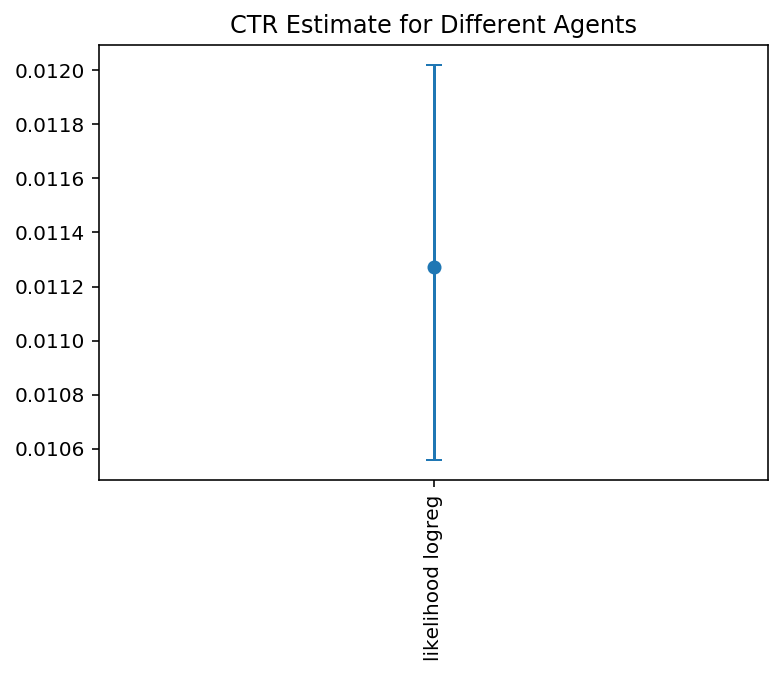

CPU times: user 18 s, sys: 276 ms, total: 18.2 s
Wall time: 18.5 s


In [10]:
%%time

result = verify_agents(get_environement(NUM_PRODUCTS), NUM_USERS, {'likelihood logreg': likelihood_logreg})
fig = plot_verify_agents(result)
plt.show()

# Step 3.B. Define and train the Contextual Bandit agent

In [11]:
class PolicyAgent(LikelihoodAgent):
    def __init__(self, feature_provider, use_argmax=False, seed=43):
        LikelihoodAgent.__init__(self, feature_provider, use_argmax=use_argmax, seed=seed)
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state.
        """
        return user_state
    
    def train(self, reco_log):
        user_states, actions, rewards, proba_actions = build_rectangular_data(reco_log, feature_provider)
        
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])        
        labels = actions
        weights = rewards / proba_actions
        
        self.model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)        
        self.model.fit(features[weights != 0], labels[weights != 0], weights[weights != 0])
    
    def _score_products(self, user_state):
        return self.model.predict_proba(self._create_features(user_state, None).reshape(1, -1))[0, :]


In [12]:
%%time

policy_logreg = PolicyAgent(count_product_views_feature_provider)
policy_logreg.train(popularity_policy_logs)

CPU times: user 17.3 s, sys: 279 ms, total: 17.6 s
Wall time: 17.7 s


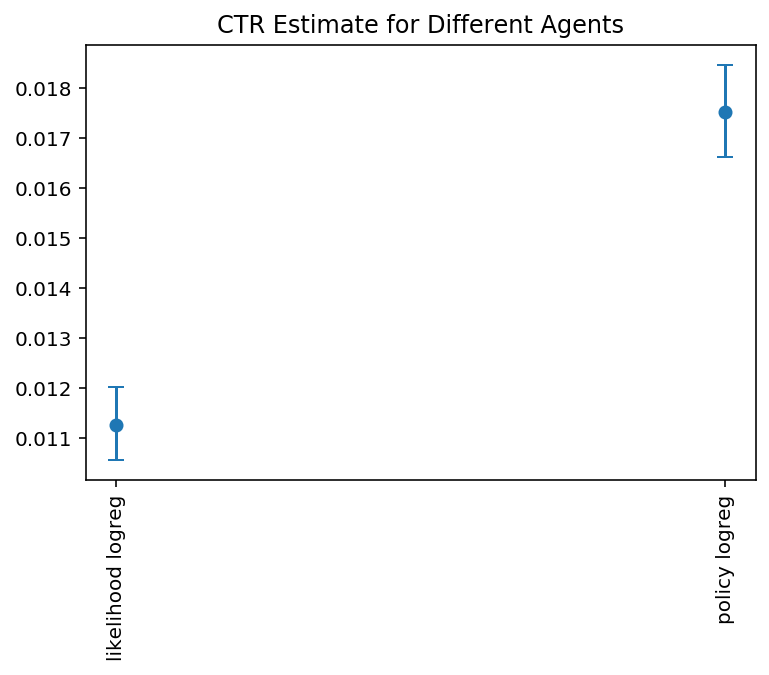

In [13]:
result = verify_agents(get_environement(NUM_PRODUCTS), NUM_USERS, {
    'likelihood logreg': likelihood_logreg, 
    'policy logreg': policy_logreg,
    
})
fig = plot_verify_agents(result)
plt.show()

# Step 3.C Define and train Contextual Bandit agent on top product embeddings space

In [14]:
# Embeddings from previous notebook
def create_embeddings(reco_log, num_products, embedding_size=5):
    organic_reco_log = reco_log[reco_log['z'] == 'organic']

    n_users = reco_log['u'].nunique()
    counts = np.zeros((n_users, num_products))

    binarizer = LabelBinarizer().fit(np.arange(num_products))
    for u in range(n_users):
        binarized_views_of_user = binarizer.transform(organic_reco_log[organic_reco_log['u'] == u]['v'])
        counts[u, :] = binarized_views_of_user.sum(axis=0)

    counts_above_zero = 1. * (counts > 0)  # above zero counts only
    co_counts = np.matmul(counts_above_zero.T, counts_above_zero)

    w, v = np.linalg.eig(co_counts)
    idx = np.argsort(w)[::-1]
    v = np.real(v[:, idx])
    w = np.real(w[idx])

    wdash = np.zeros_like(w)

    wdash[0:embedding_size] = w[0:embedding_size]
    embeddings = np.matmul(v, np.sqrt(np.diag(wdash)))[:, 0:embedding_size]  # keep the non-zero components
    return embeddings

In [15]:
class PolicyAgentWithEmbeddings(LikelihoodAgent):
    def __init__(self, feature_provider, use_argmax=False, seed=43):
        LikelihoodAgent.__init__(self, feature_provider, use_argmax=use_argmax, seed=seed)
        self.embeddings = None
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state.
        """
        # User state is the number of time each product has been seen
        # We do a weigthed average of these products and use them as features
        return np.average(self.embeddings, axis=0, weights=user_state)
    
    def train(self, reco_log):
        user_states, actions, rewards, proba_actions = build_rectangular_data(reco_log, self.feature_provider)
        self.embeddings = create_embeddings(reco_log, self.num_products)
        
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])        
        labels = actions
        weights = rewards / proba_actions
                
        self.model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)        
        self.model.fit(features[weights != 0], labels[weights != 0], weights[weights != 0])
    
    def _score_products(self, user_state):
        return self.model.predict_proba(self._create_features(user_state, None).reshape(1, -1))[0, :]


In [16]:
%%time

policy_logreg_with_embeddings = PolicyAgentWithEmbeddings(count_product_views_feature_provider)
policy_logreg_with_embeddings.train(popularity_policy_logs)

CPU times: user 25.8 s, sys: 473 ms, total: 26.2 s
Wall time: 26.7 s


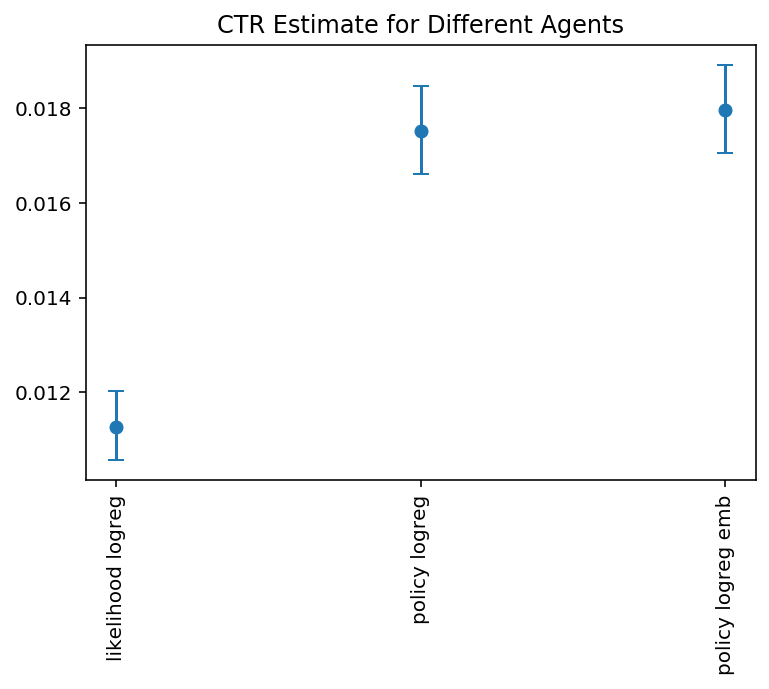

In [17]:
result = verify_agents(get_environement(NUM_PRODUCTS), NUM_USERS, {
    'likelihood logreg': likelihood_logreg, 
    'policy logreg': policy_logreg,
    'policy logreg emb': policy_logreg_with_embeddings,    
})
fig = plot_verify_agents(result)
plt.show()